In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.4.1+cu121
Torchvision version: 0.19.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-y4q6tagh
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-y4q6tagh
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
--2024-10-13 22:44:33--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.33, 13.227.219.70, 13.227.219.10, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.2’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   101MB/s    in 15s     

202

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from transformers import ViTImageProcessor, ViTForImageClassification
import webcolors

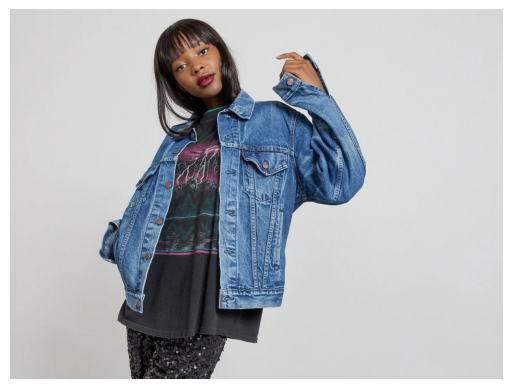

In [3]:
image_path = '/content/inv_fullxfull.3426179582_ad4qvtov.webp'
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

plt.imshow(original_image)
plt.axis('off')
plt.show()

In [4]:
import numpy as np
import webcolors

class MaskNClassifier:
  def __init__(self, sam_checkpoint, model_type, device, CLASSIFICATION_MODEL_NAME):


    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)

    self.mask_generator = SamAutomaticMaskGenerator(sam)

    self.processor = ViTImageProcessor.from_pretrained(CLASSIFICATION_MODEL_NAME)
    self.classifier = ViTForImageClassification.from_pretrained(CLASSIFICATION_MODEL_NAME)

  def get_masks(self, image):
    masks = self.mask_generator.generate(image)
    return masks

  def classify(self, image: np.ndarray) -> tuple:
    inputs = self.processor(images=image, return_tensors="pt")
    with torch.no_grad():
        logits = self.classifier(**inputs).logits

    logits = torch.softmax(logits, -1)
    confidence, idx = logits.max(-1)
    confidence, idx = confidence.item(), idx.item()
    label = self.classifier.config.id2label[idx]


    return label, confidence

  def _average_color(self, segmented_image):
    pixels = segmented_image.reshape(-1, 3).astype(float)

    non_black = pixels[np.any(pixels != [0, 0, 0], axis=1)]

    if len(non_black) > 0:
        return np.mean(non_black, axis=0).astype(int)
    else:
        return None



  def closest_colour(self, requested_colour):
      min_colours = {}
      for name in webcolors.names("css3"):
          r_c, g_c, b_c = webcolors.name_to_rgb(name)
          rd = (r_c - requested_colour[0]) ** 2
          gd = (g_c - requested_colour[1]) ** 2
          bd = (b_c - requested_colour[2]) ** 2
          min_colours[(rd + gd + bd)] = name
      return min_colours[min(min_colours.keys())]


  def _nearest_color(segmented_image, k=3):
    pixels = segmented_image.reshape(-1, 3)

    non_black = pixels[np.any(pixels != [0, 0, 0], axis=1)]

    if len(non_black) > 0:
        # Perform k-means clustering
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(non_black)

        # Get the colors
        colors = kmeans.cluster_centers_

        # Sort colors by their frequency
        labels = kmeans.labels_
        counts = np.bincount(labels)
        sorted_indices = np.argsort(counts)[::-1]

        return colors[sorted_indices].astype(int)[0]
    else:
        return None

  def get_dominant_color(self, segmented_image, type):
    if type == 'average':
      color = self._average_color(segmented_image)
    elif type == 'nearest':
      color = self._nearest_color(segmented_image)
    else:
      raise NotImplementedError

    if color is None:
      raise ValueError

    color_name = self.closest_colour(color)
    return color_name

  def get_metadata(self, image: np.ndarray, find_color='average'):
    masks = self.get_masks(image)

    metadata = {
        'bbox' : [],
        'label' : [],
        'condifence' : [],
        'color' : []
    }

    for mask in masks:
      x, y, w, h = mask['bbox']
      cropped_image = image[y:y+h, x:x+w]
      label, confidence = self.classify(cropped_image)
      color = self.get_dominant_color(cropped_image, find_color)

      metadata['bbox'].append(mask['bbox'] )
      metadata['label'].append(label)
      metadata['condifence'].append(confidence)
      metadata['color'].append(color)

    return metadata



In [5]:
CLASSIFICATION_MODEL_NAME = 'jolual2747/vit-clothes-classification'
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

clf = MaskNClassifier(sam_checkpoint, model_type, device, CLASSIFICATION_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)
/usr/local/lib/python3.10

In [6]:
md = clf.get_metadata(original_image)

[0, 2, 1199, 895] JACKETS 0.6297228336334229 darkgrey
[218, 155, 646, 582] JACKETS 0.5730066299438477 lightslategrey
[284, 776, 244, 122] LOUNGEWEAR 0.2260386049747467 darkslategrey
[220, 23, 643, 874] JACKETS 0.6518927812576294 lightslategrey
[648, 105, 119, 94] FASHION JEWELRY 0.329845130443573 grey
[263, 245, 350, 565] JACKETS 0.5273184180259705 dimgrey
[393, 80, 131, 164] FINE JEWELRY 0.5649933218955994 darkolivegreen
[263, 67, 350, 826] JACKETS 0.6237507462501526 dimgrey
[393, 80, 371, 164] FASHION JEWELRY 0.32598093152046204 grey
[350, 24, 211, 289] FINE JEWELRY 0.5317664742469788 dimgrey
[217, 512, 53, 106] COATS 0.3050417900085449 slategrey
[613, 370, 16, 18] TABLETOP 0.1123112216591835 dimgrey
[354, 509, 16, 15] KNITWEAR 0.103415846824646 dimgrey
[564, 341, 113, 64] JEWELRY 0.21465203166007996 darkslateblue
[306, 708, 12, 17] FASHION JEWELRY 0.2622620463371277 dimgrey
[1165, 0, 34, 49] FINE JEWELRY 0.8819117546081543 gainsboro
[509, 678, 157, 51] DENIM 0.24288003146648407 ligh